# Simulations of the viral load process $V_t$

Here we simulate the process 
$$V_t = \sum_{i=1}^{\infty} \mathbf{1}_{[T_i, \infty)}(t) v_0 e^{g(t-T_i)}$$
where $T_i$ are the jump times of a Poisson process with intensity $\lambda$.
The process $V_t$ is a model for the viral load after SIV/HIV treatment interruption
when multiple recrudescence events contribute to viremia.
We also simulate first passage times for this process
$$ \tau = \inf\{ t : V_t \geq \ell \} $$
which is a model for the viral rebound time when $\ell$ is the limit of detection of the viral load assay.

We then compare the simulated rebound times with our diffusion approximation 
of the first passage time distribution.
The notebook is used to make **Figures 1 and 2** in the paper.

Then we replace the Diffusion approximation with a Gamma law, which is more skewed like the process $V_t$. We use this to make **Figure S3** of the paper.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append("..")
from mrmpytools import utilities as util
from mrmpytools import simulations as sims
from mrmpytools import stats as stats
from mrmpytools import wkb as wkb

In [2]:
plt.rcParams.update({'font.size': 18})

# Figure 1

The simulation function for viral load trajectories is defined in the python module
`mrmpytools.simulations`. In jupyter, we can get some information about functions with the `?` operator

In [3]:
?sims.sampleVpath ## show documentation

Text(-0.1, 1.1, 'B')

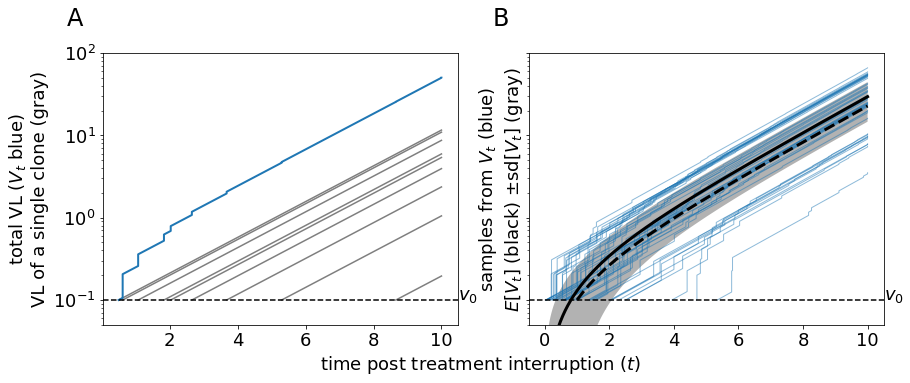

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5), sharey=True)

tmax = 10
g = 0.5
v0 = 0.1
lam0 = 1.0

## sample a single V_t path

Vtots, Ts = sims.sampleVpath(tmax, g, v0, lam0)
ax1.plot(*util.unzip([(t, v) for t, v in Vtots if v > 0]), 
         color='tab:blue', linewidth=2, zorder=2)
for t in Ts:
    ax1.plot([t, tmax], [v0, v0*np.exp(g*(tmax-t))], color='tab:gray', zorder=1)

ax1.axhline(y=v0, linestyle='--', color='k')
ax1.text(tmax+0.5, v0, "$v_0$")
    
ax1.set_yscale('log')
ax1.set_ylabel("total VL ($V_t$ blue)\nVL of a single clone (gray)")


fig.text(0.5, 0, "time post treatment interruption ($t$)", ha='center')

## sample a whole bunch of V_t paths

for i in range(50):
    Vtots, Ts = sims.sampleVpath(tmax, g, v0, lam0)
    ax2.plot(*util.unzip([(t, v) for t, v in Vtots if v > 0]), 
             color='tab:blue', linewidth=1, alpha=0.5)

ax2.set_yscale('log')
ax2.axhline(y=v0, linestyle='--', color='k')
ax2.text(tmax+0.5, v0, "$v_0$")

## add the expected value

ts = np.linspace(1e-5, tmax, 1000) ## don't include t = 0
EVts = [stats.expectedVt(t, g, v0, lam0) for t in ts]
t0 = 1/lam0
tldts = [t for t in ts if t >= t0]
tldVts = [stats.tildeVt(t, g, v0, lam0, t0) for t in tldts]

ax2.plot(ts, EVts, color='k', linewidth=3, zorder=2)
ax2.plot(tldts, tldVts, color='k', linewidth=3, zorder=2, linestyle='--')
ax2.set_ylim(0.05, 1e2)

## indicate uncertainty with +/- standard deviation

sdVts = [stats.sdVt(t, g, v0, lam0) for t in ts]
lowVts = [e - s for e, s in zip(EVts, sdVts)]
hiVts = [e + s for e, s in zip(EVts, sdVts)]

ax2.fill_between(ts, lowVts, hiVts, color='k', linewidth=0, alpha=0.3)

ax2.set_ylabel("samples from $V_t$ (blue)\n$E[V_t]$ (black) $\pm \mathsf{sd}[V_t]$ (gray)")

ax1.text(-0.1, 1.1, "A", fontsize=24, transform=ax1.transAxes)
ax2.text(-0.1, 1.1, "B", fontsize=24, transform=ax2.transAxes)

#fig.savefig("../Figure1.pdf", bbox_inches='tight')

# Figure 2

Now, we sample first passage times of the process $V_t$. This is easy, because between jumps of size $v_0$, the process grows exponentially with rate $g$. Hence, we can calculate exactly then the limit of detection $\ell$ is crossed. We compare these exact rebound time simulations with our diffusion approximation, which we derive by replacing the (unknown) distribution of $V_t$ with a normal distribution of mean $\kappa_1(t)$ and variance $\kappa_2(t)$.

The first-passage-time (FPT) simulator `sampeFPT` is defined in `mrmpytools.simulations` 
and the PDF of the diffusion approximation `FPTpdf` can be found in `mrmpytools.stats`

Text(0.5, 0.02, 'time to detection (days)')

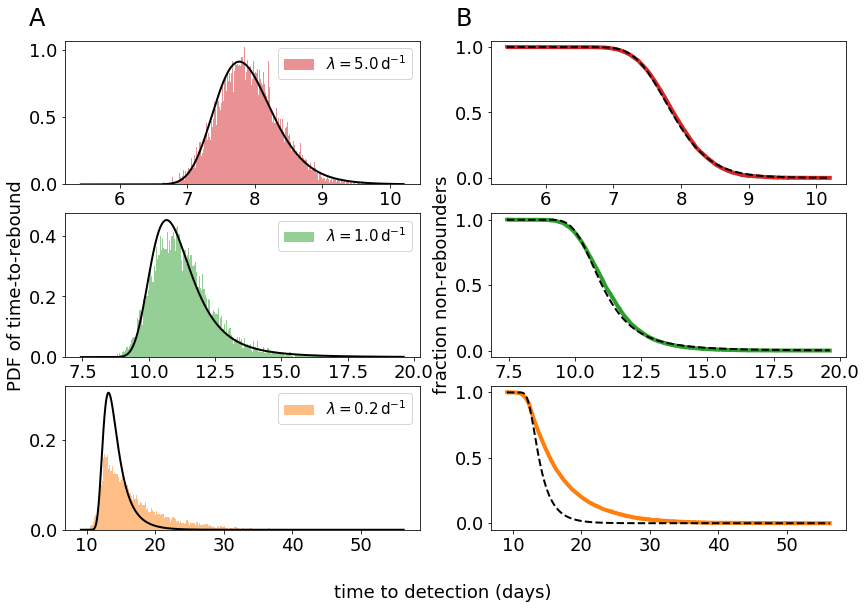

In [5]:
ell = 50
g = 0.5
v0 = 0.1
lam0s = [5.0, 1.0, 0.2]
colors = ['tab:red', 'tab:green', 'tab:orange']

fig, axs = plt.subplots(len(lam0s), 2, figsize=(14,9), sharex='row')

num_samples = 10000
num_bins = 250

for i, lam0 in enumerate(lam0s):
    color = colors[i]
    ax1, ax2 = axs[i]
    samples = [sims.sampleFPT(ell, g, v0, lam0) for _ in range(num_samples)]

    ax1.hist(samples, num_bins, density=True, color=color, alpha=0.5, 
             label=f'$\\lambda = {lam0}\\, \\mathsf{{d}}^{{-1}}$')
    ax1.legend(loc='upper right', fontsize='small')

    ## emperical survival function
    events = [np.min(samples)-1] + sorted(samples)
    fractions = np.linspace(1, 0, len(events))
    ax2.step(events, fractions, color=color, linewidth=4, zorder=1)

    ts = np.linspace(np.min(samples)-1, np.max(samples), 1000)
    fs = [stats.FPTpdf(t, ell, v0, lam0, g) for t in ts]
    Ss = [1-stats.FPTcdf(t, ell, v0, lam0, g) for t in ts]

    ax1.plot(ts, fs, linewidth=2, color='k')
    ax2.plot(ts, Ss, linewidth=2, color='k', zorder=2, linestyle='--')

axs[0,0].text(-0.1, 1.1, "A", fontsize=24, transform=axs[0,0].transAxes)
axs[0,1].text(-0.1, 1.1, "B", fontsize=24, transform=axs[0,1].transAxes)

axs[1,0].set_ylabel("PDF of time-to-rebound")

axs[1,1].set_ylabel("fraction non-rebounders")

fig.text(0.5, 0.02, "time to detection (days)", ha='center')

#fig.savefig("../Figure2.pdf", bbox_inches='tight')

# Figure S3

Improve the similarity between the emperical rebound-time distribution and the approximation by replacing the Gaussian approximation for the law of $V_t$ with a skewed Gamma law.

Text(0.5, 0.02, 'time to detection (days)')

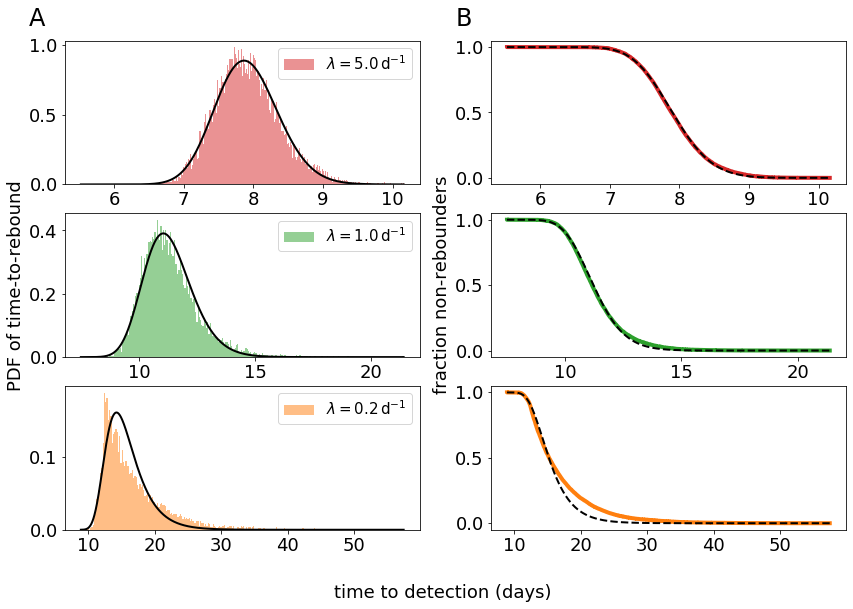

In [6]:
ell = 50
g = 0.5
v0 = 0.1
lam0s = [5.0, 1.0, 0.2]
colors = ['tab:red', 'tab:green', 'tab:orange']

fig, axs = plt.subplots(len(lam0s), 2, figsize=(14,9), sharex='row')

num_samples = 10000
num_bins = 250

for i, lam0 in enumerate(lam0s):
    color = colors[i]
    ax1, ax2 = axs[i]
    samples = [sims.sampleFPT(ell, g, v0, lam0) for _ in range(num_samples)]

    ax1.hist(samples, num_bins, density=True, color=color, alpha=0.5, 
             label=f'$\\lambda = {lam0}\\, \\mathsf{{d}}^{{-1}}$')
    ax1.legend(loc='upper right', fontsize='small')

    ## emperical survival function
    events = [np.min(samples)-1] + sorted(samples)
    fractions = np.linspace(1, 0, len(events))
    ax2.step(events, fractions, color=color, linewidth=4, zorder=1)

    ts = np.linspace(np.min(samples)-1, np.max(samples), 1000)
    fs = [stats.gammaFPTpdf(t, ell, v0, lam0, g) for t in ts]
    Ss = [stats.gammaFPTccdf(t, ell, v0, lam0, g) for t in ts]

    ax1.plot(ts, fs, linewidth=2, color='k')
    ax2.plot(ts, Ss, linewidth=2, color='k', zorder=2, linestyle='--')

axs[0,0].text(-0.1, 1.1, "A", fontsize=24, transform=axs[0,0].transAxes)
axs[0,1].text(-0.1, 1.1, "B", fontsize=24, transform=axs[0,1].transAxes)

axs[1,0].set_ylabel("PDF of time-to-rebound")

axs[1,1].set_ylabel("fraction non-rebounders")

fig.text(0.5, 0.02, "time to detection (days)", ha='center')

#fig.savefig("../Figure2-gamma.pdf", bbox_inches='tight')

# Figure S4

Now use the WKB approximation of the master equation to derive a first passage time distrobution for the process $V_t$. Use the functions defined in the `mrmpytools.wkb` module

/home/chris/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 5.816194e-09
  AccuracyWarning)
/home/chris/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 1.163917e-10
  AccuracyWarning)
/home/chris/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.947918e-09
  AccuracyWarning)
/home/chris/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:199: AccuracyWarning: maxiter (1000) exceeded. Latest difference = 7.332042e-09
  AccuracyWarning)


Text(0.5, 0.02, 'time to detection (days)')

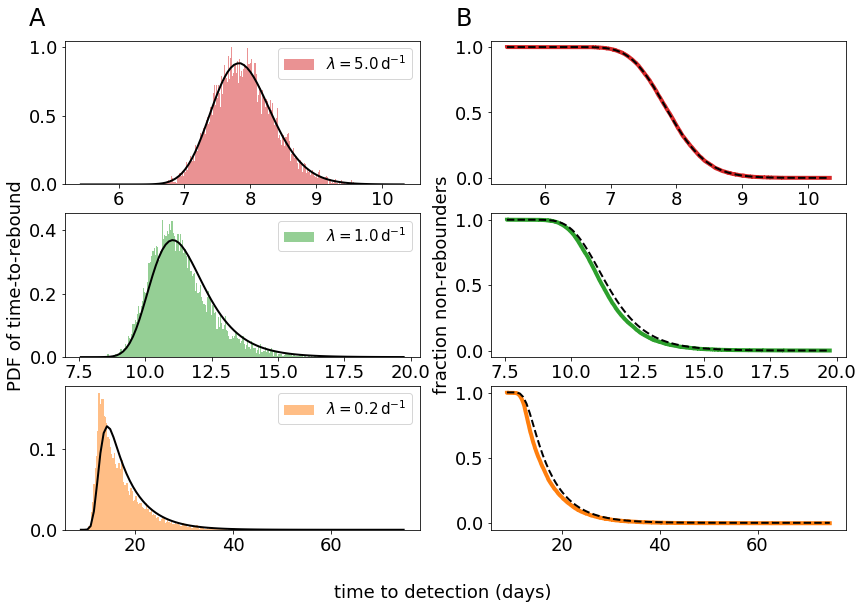

In [7]:
ell = 50
g = 0.5
v0 = 0.1
lam0s = [5.0, 1.0, 0.2]
colors = ['tab:red', 'tab:green', 'tab:orange']

fig, axs = plt.subplots(len(lam0s), 2, figsize=(14,9), sharex='row')

num_samples = 10000
num_bins = 250

for i, lam0 in enumerate(lam0s):
    color = colors[i]
    ax1, ax2 = axs[i]
    samples = [sims.sampleFPT(ell, g, v0, lam0) for _ in range(num_samples)]

    ax1.hist(samples, num_bins, density=True, color=color, alpha=0.5, 
             label=f'$\\lambda = {lam0}\\, \\mathsf{{d}}^{{-1}}$')
    ax1.legend(loc='upper right', fontsize='small')

    ## emperical survival function
    events = [np.min(samples)-1] + sorted(samples)
    fractions = np.linspace(1, 0, len(events))
    ax2.step(events, fractions, color=color, linewidth=4, zorder=1)

    tmin, tmax = np.min(samples)-1, np.max(samples) 
    ts = np.linspace(tmin, tmax, 100)
    fs = wkb.FPTpdfWKBlim(ts, ell, (g, lam0, v0))
    f_inter = wkb.FPTpdfWKBinter(ts, fs) ## interpolation function
    Ss = [wkb.FPTccdfWKB(f_inter, t) for t in ts]
 
    ax1.plot(ts, fs, linewidth=2, color='k')
    ax2.plot(ts, Ss, linewidth=2, color='k', zorder=2, linestyle='--')

axs[0,0].text(-0.1, 1.1, "A", fontsize=24, transform=axs[0,0].transAxes)
axs[0,1].text(-0.1, 1.1, "B", fontsize=24, transform=axs[0,1].transAxes)

axs[1,0].set_ylabel("PDF of time-to-rebound")

axs[1,1].set_ylabel("fraction non-rebounders")

fig.text(0.5, 0.02, "time to detection (days)", ha='center')

# fig.savefig("../Figure2-WKB.pdf", bbox_inches='tight')

# Adjust the FPT distribution to account for variable growth rate $G$

Derive mean and variance using the random-G model, then we can correct the FPT distribution.
We have 
$$
\mathbb{E}[V_t] = v_0 \lambda \int_0^t \mathbb{E}[e^{Gs}] ds
$$
with $G \sim h \mapsto \frac{h}{u(g-u/2)}\mathbf{1}_{[g-u, u]}(h)$.
This evaluates as 
$$
\kappa_1 = \mathbb{E}[V_t] = \frac{v_0 \lambda}{g-u/2} \left( e^{gt} \frac{1-e^{-ut}}{ut} -1 \right)
$$
Similarly, we have
$$
\mathrm{Var}[V_t] = v_0^2 \lambda \int_0^t \mathbb{E}[e^{2Gs}] ds
$$
and this is equal to
$$
\kappa_2 = \mathrm{Var}[V_t] = \frac{v_0^2 \lambda}{2g - u} \left(e^{2gt} \frac{1-e^{-2ut}}{2ut}-1\right)
$$
These (and other) functions are defined in the `mrmpytools.stats` module

# Figure S5

Figure for SI demonstrating the $G$ distribution and realizations of the model

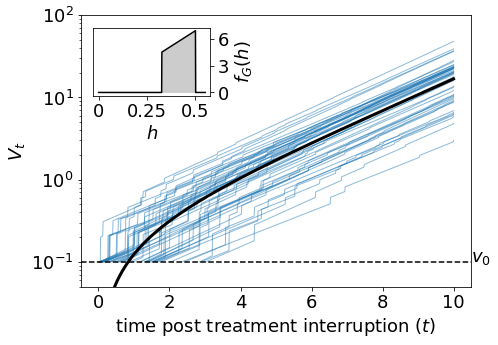

In [8]:
num_trajs = 50
tmax = 10

lam0 = 1.0
g = 0.5
v0 = 0.1
sigma = 0.05 ## sd of the growth rate g
ell = 50.0
u = stats.solve_u(sigma, g)

## distribution of g
ggen_trunc_propto = stats.gen_ggen_trunc_propto(sigma, g)

Vtss = [sims.sampleVGpath(tmax, ggen_trunc_propto, v0, lam0)[0] for _ in range(num_trajs)]

fig, ax1 = plt.subplots(1, 1, figsize=(7,5))

## plot simulations
for Vtots in Vtss:
    ax1.plot(*util.unzip([(t, v) for t, v in Vtots if v > 0]), 
             color='tab:blue', linewidth=1, alpha=0.5)

## plot standard error
ax1.set_yscale('log')
ax1.set_xlabel("time post treatment interruption ($t$)")
ax1.set_ylabel("$V_t$")
ax1.axhline(y=v0, color='k', linestyle='--')
ax1.text(tmax+0.5, v0, "$v_0$")

ts = np.linspace(1e-5, tmax, 1000)
EVts = [stats.kappaG1(t, g, lam0, v0, u) for t in ts]
ax1.plot(ts, EVts, color='k', linewidth=3, zorder=2)


ax1.set_ylim(5e-2, 1e2)

ax2 = inset_axes(ax1, "30%", "25%", loc=2, borderpad=0.7)

hs = np.linspace(0, g*1.1, 1000)
ps = [h/(u*(g-u/2)) if h >= g-u and h <= g else 0 for h in hs]

ax2.yaxis.set_label_position("right")
ax2.yaxis.set_ticks_position("right")
ax2.plot(hs, ps, color='k')
ax2.fill_between(hs, ps, color='k', alpha=0.2, linewidth=0)
ax2.set_xlabel("$h$")
ax2.set_ylabel("$f_G(h)$")
ax2.set_xticks([0, 0.25, 0.5])
ax2.set_xticklabels(["0", "0.25", "0.5"])
ax2.set_yticks([0, 3, 6])


#fig.savefig("../traj-randomG.pdf", bbox_inches='tight')

# Figure S6

Compare the corrected FPT distribution with simulated rebound times from the generalized model.
First sample rebound times. **This can take some time**

In [9]:
lam0s = [5.0, 1.0, 0.2]
g = 0.5
v0 = 0.1
sigma = 0.05 ## sd of the growth rate g
ell = 50.0
u = stats.solve_u(sigma, g)

ggen_trunc_propto = stats.gen_ggen_trunc_propto(sigma, g)

num_samples = 1000 ## use 10000 for better figure...

sampless = [[sims.sampleGReboundTime(ell, ggen_trunc_propto, v0, lam0) 
            for _ in range(num_samples)] for lam0 in lam0s]

Then make the figure

Text(0.5, 0.02, 'time to detection (days)')

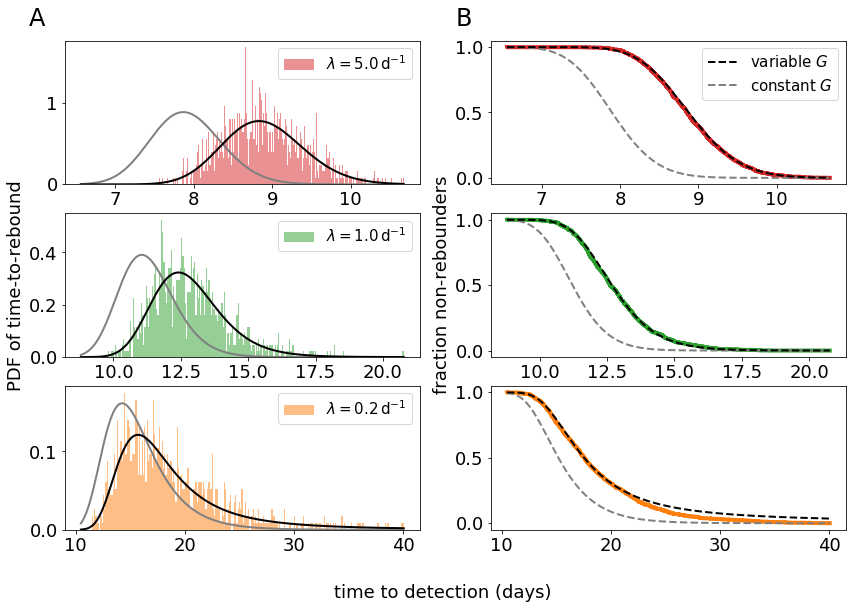

In [10]:
colors = ['tab:red', 'tab:green', 'tab:orange']

fig, axs = plt.subplots(len(lam0s), 2, figsize=(14,9), sharex='row')

num_bins = 250

for i, lam0 in enumerate(lam0s):
    color = colors[i]
    ax1, ax2 = axs[i]
    samples = sampless[i]

    ax1.hist(samples, num_bins, density=True, color=color, alpha=0.5, 
             label=f'$\\lambda = {lam0}\\, \\mathsf{{d}}^{{-1}}$')

    ## emperical survival function
    events = [np.min(samples)-1] + sorted(samples)
    fractions = np.linspace(1, 0, len(events))
    ax2.step(events, fractions, color=color, linewidth=4, zorder=1)

    ts = np.linspace(np.min(samples)-1, np.max(samples), 1000)
    fs = [stats.gammaFPTpdfG(t, ell, v0, lam0, g, u) for t in ts]
    Ss = [stats.gammaFPTccdfG(t, ell, v0, lam0, g, u) for t in ts]

    ax1.plot(ts, fs, linewidth=2, color='k', zorder=3)
    ax2.plot(ts, Ss, linewidth=2, color='k', zorder=3, 
             linestyle='--', label="variable $G$")
    
    fs_fixedG = [stats.gammaFPTpdf(t, ell, v0, lam0, g) for t in ts]
    Ss_fixedG = [stats.gammaFPTccdf(t, ell, v0, lam0, g) for t in ts]

    ax1.plot(ts, fs_fixedG, linewidth=2, color='gray', zorder=2)
    ax2.plot(ts, Ss_fixedG, linewidth=2, color='gray', zorder=2, 
             linestyle='--', label="constant $G$")

    ax1.legend(loc='upper right', fontsize='small')
    if i == 0:
        ax2.legend(loc='upper right', fontsize='small')


axs[0,0].text(-0.1, 1.1, "A", fontsize=24, transform=axs[0,0].transAxes)
axs[0,1].text(-0.1, 1.1, "B", fontsize=24, transform=axs[0,1].transAxes)

axs[1,0].set_ylabel("PDF of time-to-rebound")

axs[1,1].set_ylabel("fraction non-rebounders")

fig.text(0.5, 0.02, "time to detection (days)", ha='center')


#fig.savefig("../Figure2-gamma-randomG.pdf", bbox_inches='tight')